In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from keras import optimizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
print(os.listdir('/content/drive/My Drive/Dataset'))

['asl_test', 'asl_train', 'asl_selfgenerated_test']


**Plotting one image from each class :**

In [ ]:
train_dir ='/content/drive/My Drive/Dataset/asl_train'
test_dir ='/content/drive/My Drive/Dataset/asl_selfgenerated_test'

unique_labels =  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


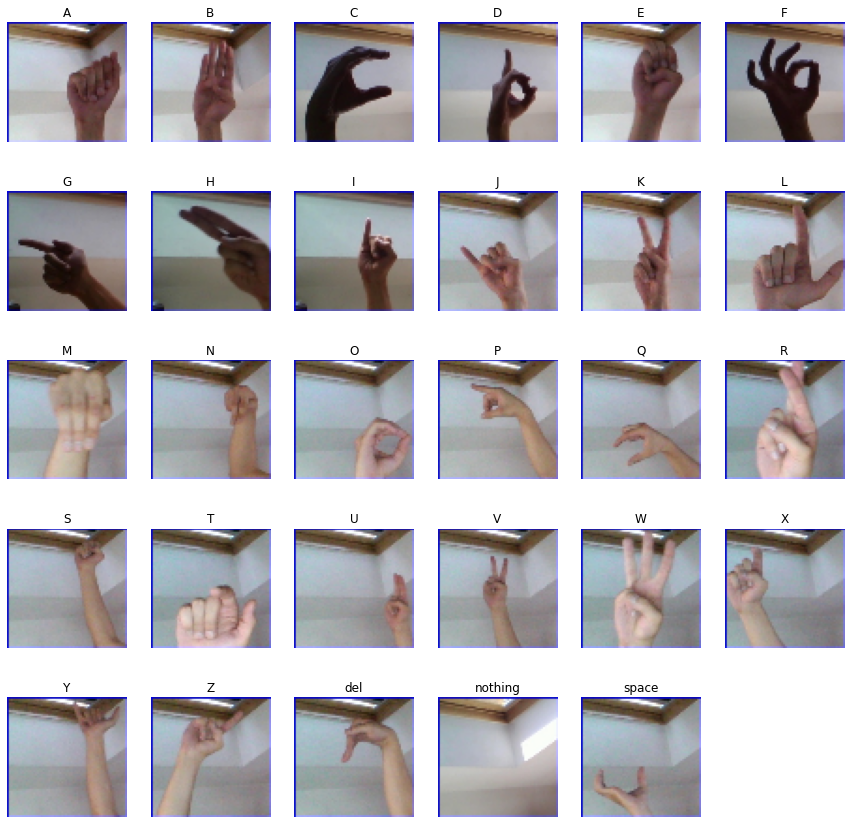

In [ ]:
def load_unique():
    size_img = 64,64 
    images_for_plot = []
    labels_for_plot = []
    for folder in sorted(os.listdir(train_dir)):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

**LOADING DATA**
1. Defining a dictionary which contains labels and its mapping to a number which acts as class label.
2. loading image data and labels and then mapping those labels to the dictionary defined before.
3. Normalizing image data.
4. converting labels to one hot format.
5. creating training and test data by splitting original data into 95% of training data and 5% testing data.

In [ ]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in sorted(os.listdir(train_dir)):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.05)
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [ ]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : A | B | C | D | E | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | T | U | V | W | X | Y | Z | del | nothing | space | 
Loaded 13779 images for training, Train data shape = (13779, 64, 64, 3)
Loaded 726 images for testing Test data shape = (726, 64, 64, 3)


**DEFINING MODEL**

In [ ]:
 def create_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (64,64,3)))
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu')) #tanh 
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(128, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(256, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(29, activation = 'softmax'))
    opt=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
    model.compile(optimizer = opt, loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    
    print("MODEL CREATED")
    model.summary()
    
    return model

def fit_model():
    model_hist = model.fit(X_train, Y_train, batch_size = 128, epochs =200, validation_split = 0.5)
    return model_hist 

**COMPILING THE MODEL AND FITTING THE TRAINING DATA**

In [ ]:
model = create_model()
curr_model_hist = fit_model()

MODEL CREATED
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 

**Plotting the model performance metrics to check model performance.**

In [ ]:
type(curr_model_hist)

tensorflow.python.keras.callbacks.History

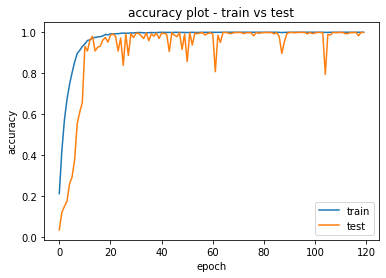

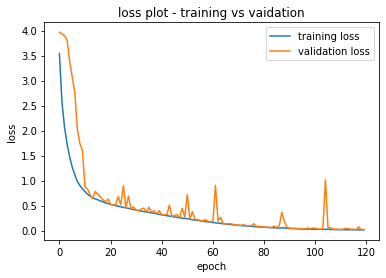

In [ ]:
plt.plot(curr_model_hist.history['accuracy'])
plt.plot(curr_model_hist.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(curr_model_hist.history['loss'])
plt.plot(curr_model_hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

**EVALUATING THE TRAINED MODEL ON THE TEST DATA SPLIT **

In [ ]:
score = model.evaluate(x = X_test, y = Y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
print("\nEvaluation loss = " ,"{:.6f}".format(score[0]))

Accuracy for test images: 99.862 %

Evaluation loss =  0.022153


In [ ]:
import sklearn
ypred = model.predict_classes(X_test)
#sklearn.metrics.confusion_matrix(Y_test, ypred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
import tensorflow as tf
labe = tf.argmax(Y_test[0], axis=0)

In [ ]:
ytest_conv = [np.where(each_arr==1)[0][0] for each_arr in Y_test]
ypred_conv = [ele for ele in ypred]

In [ ]:
[(i,j) for i,j in zip(Y_test,ytest_conv)]

[(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 0),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), 28),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 12),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 16),
 (array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 7),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 15),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
cm = sklearn.metrics.confusion_matrix(ytest_conv, ypred)
cm

array([[35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 27,  0,  0,  0,  0,  0,  0,  0,  

In [ ]:
sklearn.metrics.accuracy_score(ytest_conv, ypred)

0.9986225895316805

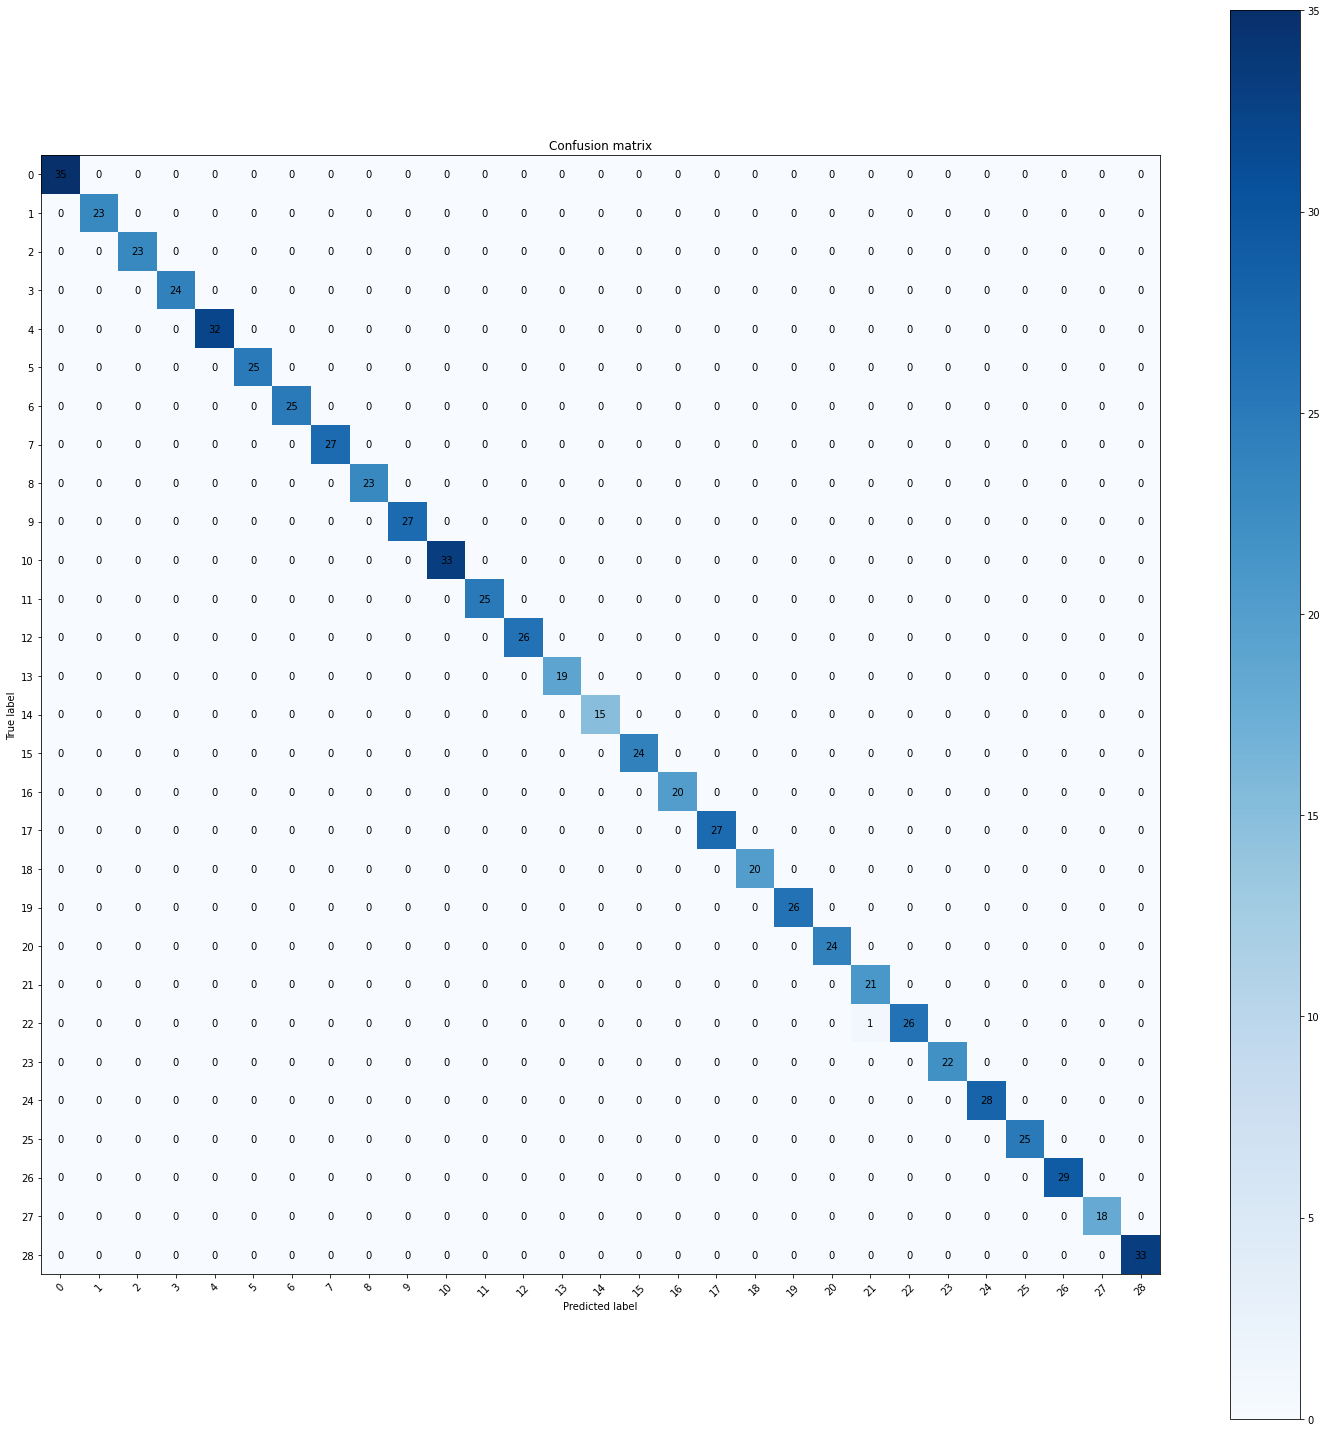

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#cm = np.array([[13,  0,  0],[ 0, 10,  6],[ 0,  0,  9]])
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, set(ytest_conv))

In [ ]:
[(r,ytest_conv.count(r)) for r in set(ytest_conv)]

[(0, 35),
 (1, 23),
 (2, 23),
 (3, 24),
 (4, 32),
 (5, 25),
 (6, 25),
 (7, 27),
 (8, 23),
 (9, 27),
 (10, 33),
 (11, 25),
 (12, 26),
 (13, 19),
 (14, 15),
 (15, 24),
 (16, 20),
 (17, 27),
 (18, 20),
 (19, 26),
 (20, 24),
 (21, 21),
 (22, 27),
 (23, 22),
 (24, 28),
 (25, 25),
 (26, 29),
 (27, 18),
 (28, 33)]

Loading the test data Provided. 
* The test data contains images with the image name as the class, to which the image belongs to.
* we will load the data and check if the predition is correct for the image.

In [ ]:
def load_test_data():
    images = []
    names = []
    size = 64,64
    for image in sorted(os.listdir(test_dir)):
        temp = cv2.imread(test_dir + '/' + image)
        temp = cv2.resize(temp, size)
        images.append(temp)
        names.append(image)
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names

test_images, test_img_names = load_test_data()

In [ ]:
# make predictions on an image and append it to the list (predictions).
predictions = [model.predict_classes(image.reshape(1,64,64,3))[0] for image in test_images]

In [ ]:
def get_labels_for_plot(predictions):
    predictions_labels = []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

predictions_labels_plot = get_labels_for_plot(predictions)

In [ ]:
model.save("model.h5")

PLOTTING THE TEST DATA ALONG WITH THE PREDICTION MADE BY THE MODEL

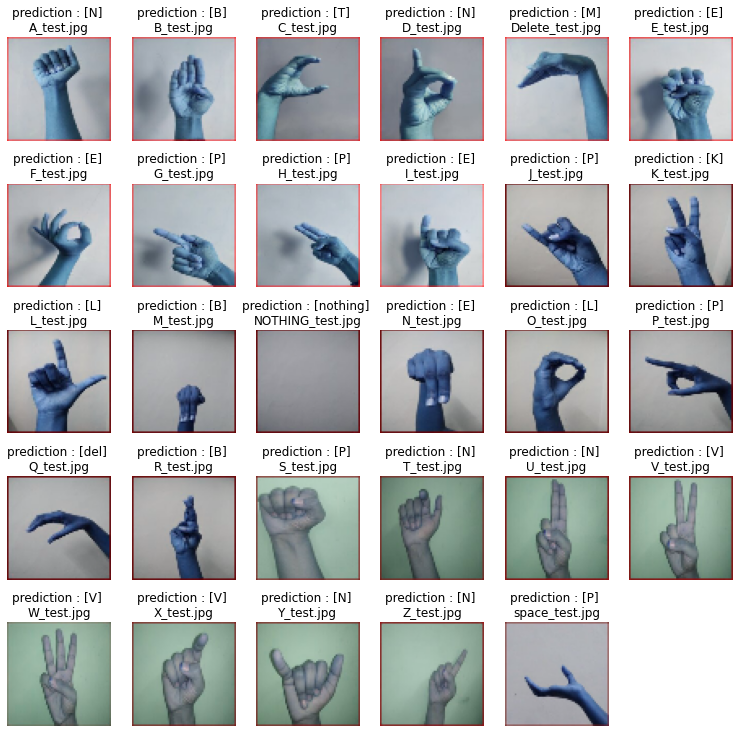

In [ ]:
predfigure = plt.figure(figsize = (13,13))
def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_image_1(predfigure, test_images[image_index], test_img_names[image_index], predictions[image_index], predictions_labels_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

As we can see the predictions are correct for almost all the images. Thus the model performs well on the test set.